> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

- This NB is based off of NB107.  
- May want to log, save, and write all the decs from NBs 201/202.  
- Not sure whether it is worth testing on all conditions (e.g. to generate more training data for this adversarial model). I did so since there were so few instances of each class in the training data otherwise.  Well really each update doesn't matter only the user so maybe I didn't need to do that   
- Also should save the models from earlier NBs (102, 104, 106, 107) and see how they perform on this data
- Plot adversarial accuracy wrt each local iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *
from experiment_params import *
from fl_sim_classes import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
#import warnings
#warnings.filterwarnings("ignore")

random.seed(a=1)

## Load Data

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

In [3]:
with open('Data\continuous_full_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

cond1b1_dict_list = [0]*num_participants
cond2b1_dict_list = [0]*num_participants
cond3b1_dict_list = [0]*num_participants
cond4b1_dict_list = [0]*num_participants
cond5b1_dict_list = [0]*num_participants
cond6b1_dict_list = [0]*num_participants
cond7b1_dict_list = [0]*num_participants
cond8b1_dict_list = [0]*num_participants
for idx in range(num_participants):
    b1_emg = emgs_block1[keys[idx]]
    b1_ref = refs_block1[keys[idx]]
    cond1b1_dict_list[idx] = {'training':b1_emg[0,:,:], 'labels':b1_ref[0,:,:]}
    cond2b1_dict_list[idx] = {'training':b1_emg[1,:,:], 'labels':b1_ref[1,:,:]}
    cond3b1_dict_list[idx] = {'training':b1_emg[2,:,:], 'labels':b1_ref[2,:,:]}
    cond4b1_dict_list[idx] = {'training':b1_emg[3,:,:], 'labels':b1_ref[3,:,:]}
    cond5b1_dict_list[idx] = {'training':b1_emg[4,:,:], 'labels':b1_ref[4,:,:]}
    cond6b1_dict_list[idx] = {'training':b1_emg[5,:,:], 'labels':b1_ref[5,:,:]}
    cond7b1_dict_list[idx] = {'training':b1_emg[6,:,:], 'labels':b1_ref[6,:,:]}
    cond8b1_dict_list[idx] = {'training':b1_emg[7,:,:], 'labels':b1_ref[7,:,:]}
    
    cond1b1_AllInitDecs_list = [Ws_block1[keys[i]][0, 0, :, :] for i in range(num_participants)]
    cond2b1_AllInitDecs_list = [Ws_block1[keys[i]][1, 0, :, :] for i in range(num_participants)]
    cond3b1_AllInitDecs_list = [Ws_block1[keys[i]][2, 0, :, :] for i in range(num_participants)]
    cond4b1_AllInitDecs_list = [Ws_block1[keys[i]][3, 0, :, :] for i in range(num_participants)]
    cond5b1_AllInitDecs_list = [Ws_block1[keys[i]][4, 0, :, :] for i in range(num_participants)]
    cond6b1_AllInitDecs_list = [Ws_block1[keys[i]][5, 0, :, :] for i in range(num_participants)]
    cond7b1_AllInitDecs_list = [Ws_block1[keys[i]][6, 0, :, :] for i in range(num_participants)]
    cond8b1_AllInitDecs_list = [Ws_block1[keys[i]][7, 0, :, :] for i in range(num_participants)]


## No-FL Case

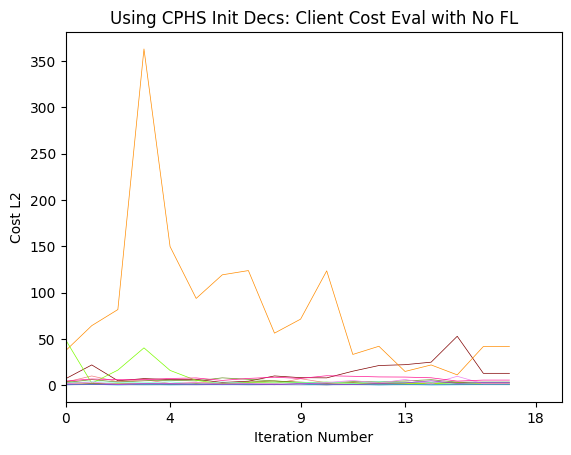

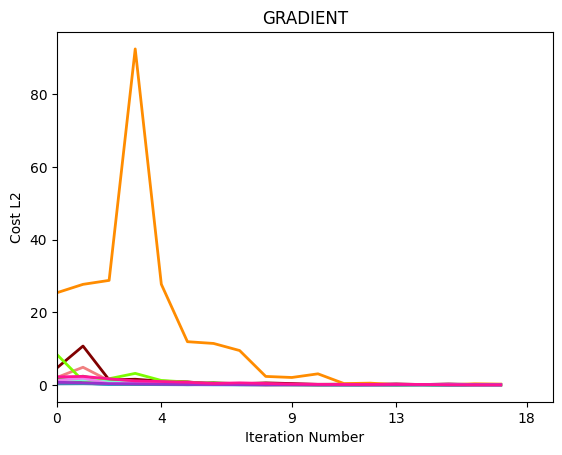

In [4]:
users_c1 = [Client(i, cond1b1_AllInitDecs_list[i], 'FullScipyMinStep', cond1b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_c1 = Server(-1, D_0, 'NoFL', users_c1, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_c1.execute_FL_loop()
    
condensed_external_plotting(users_c1, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')
condensed_external_plotting(users_c1, 'local', plot_gradient=True, dim_reduc_factor=1, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

In [5]:
users_c2 = [Client(i, cond2b1_AllInitDecs_list[i], 'FullScipyMinStep', cond2b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=2, delay_scaling=0) for i in range(14)]
global_c2 = Server(-1, D_0, 'NoFL', users_c2, PCA_comps=64)

users_c3 = [Client(i, cond3b1_AllInitDecs_list[i], 'FullScipyMinStep', cond3b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=3, delay_scaling=0) for i in range(14)]
global_c3 = Server(-1, D_0, 'NoFL', users_c3, PCA_comps=64)

users_c4 = [Client(i, cond4b1_AllInitDecs_list[i], 'FullScipyMinStep', cond4b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=4, delay_scaling=0) for i in range(14)]
global_c4 = Server(-1, D_0, 'NoFL', users_c4, PCA_comps=64)

users_c5 = [Client(i, cond5b1_AllInitDecs_list[i], 'FullScipyMinStep', cond5b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=5, delay_scaling=0) for i in range(14)]
global_c5 = Server(-1, D_0, 'NoFL', users_c5, PCA_comps=64)

users_c6 = [Client(i, cond6b1_AllInitDecs_list[i], 'FullScipyMinStep', cond6b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=6, delay_scaling=0) for i in range(14)]
global_c6 = Server(-1, D_0, 'NoFL', users_c6, PCA_comps=64)

users_c7 = [Client(i, cond7b1_AllInitDecs_list[i], 'FullScipyMinStep', cond7b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=7, delay_scaling=0) for i in range(14)]
global_c7 = Server(-1, D_0, 'NoFL', users_c7, PCA_comps=64)

users_c8 = [Client(i, cond8b1_AllInitDecs_list[i], 'FullScipyMinStep', cond8b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=8, delay_scaling=0) for i in range(14)]
global_c8 = Server(-1, D_0, 'NoFL', users_c8, PCA_comps=64)

num_updates_left = 19
for i in range(num_updates_left):
    global_c2.execute_FL_loop()
    global_c3.execute_FL_loop()
    global_c4.execute_FL_loop()
    global_c5.execute_FL_loop()
    global_c6.execute_FL_loop()
    global_c7.execute_FL_loop()
    global_c8.execute_FL_loop()

In [6]:
t0 = time.time()

dec_flattened1 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened2 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened3 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened4 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened5 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened6 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened7 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened8 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
for key_idx, key in enumerate(keys):
    for update_number, update_idx in enumerate(update_ix):
        dec_flattened1.loc[len(dec_flattened1)] = [key, update_number, np.ravel(users_c1[key_idx].dec_log[update_number])]
        dec_flattened2.loc[len(dec_flattened2)] = [key, update_number, np.ravel(users_c2[key_idx].dec_log[update_number])]
        dec_flattened3.loc[len(dec_flattened3)] = [key, update_number, np.ravel(users_c3[key_idx].dec_log[update_number])]
        dec_flattened4.loc[len(dec_flattened4)] = [key, update_number, np.ravel(users_c4[key_idx].dec_log[update_number])]
        dec_flattened5.loc[len(dec_flattened5)] = [key, update_number, np.ravel(users_c5[key_idx].dec_log[update_number])]
        dec_flattened6.loc[len(dec_flattened6)] = [key, update_number, np.ravel(users_c6[key_idx].dec_log[update_number])]
        dec_flattened7.loc[len(dec_flattened7)] = [key, update_number, np.ravel(users_c7[key_idx].dec_log[update_number])]
        dec_flattened8.loc[len(dec_flattened8)] = [key, update_number, np.ravel(users_c8[key_idx].dec_log[update_number])]        
        
t1 = time.time()
total = t1-t0  
print(total)

3.0130250453948975


In [20]:
# Concat all the dfs into a single training input dataframe
dec_flattened = pd.concat([dec_flattened1, dec_flattened2, dec_flattened3, dec_flattened4, dec_flattened5, dec_flattened6, dec_flattened7, dec_flattened8], ignore_index=True, axis=0)

# Make each ele its own cell
expanded_dec_df = dec_flattened.join(dec_flattened['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
print(expanded_dec_df.shape)
expanded_dec_df.head()

(2128, 130)


,Subject,Update Number,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,0.001421,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
1,METACPHS_S106,1,0.001243,0.002463,0.000509,0.006686,0.003009,0.000508,0.001013,-0.000711,...,0.003395,0.005837,0.005295,0.000999,0.001312,0.005053,0.008816,0.007758,0.006377,0.000240
2,METACPHS_S106,2,-0.000372,0.003810,-0.000075,0.005709,0.000862,-0.000247,-0.004618,-0.004766,...,0.001921,0.004090,0.003355,0.000977,0.002347,0.004636,0.005648,0.002985,0.001597,-0.003138
3,METACPHS_S106,3,0.001009,0.002855,-0.000121,0.005214,-0.002227,-0.003420,0.000007,-0.011986,...,-0.000223,0.003248,0.003910,0.002329,0.003220,0.004468,0.007297,0.001446,0.004493,-0.006419
4,METACPHS_S106,4,-0.000174,0.001306,-0.001158,0.004879,-0.001811,-0.005817,-0.001812,-0.010339,...,0.002242,0.000138,0.000030,0.001989,0.002812,0.004116,0.007054,0.003373,0.004395,-0.007981


In [10]:
assert(np.sum(expanded_dec_df.isnull().values)==0)

# Adversarial Modeling

In [11]:
#my_models = [LogisticRegression(), KNeighborsClassifier(), GradientBoostingClassifier()]
my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [21]:
def make_all_update_models(flattened_input_df, num_kfolds=5, stratification=my_strat, my_metrics_columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds'], my_models_list=[LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], make_df=True, full_test_df=pd.DataFrame()):

    if make_df:
        full_test_df = pd.DataFrame(columns=my_metrics_columns)

    for i in range(19):
        print(f"{i} of {19}")
        ith_df, ith_test_df = nth_decoder_model(flattened_input_df, i, my_models_list, stratification=my_strat, cv=num_kfolds, test=True)

        full_test_df = pd.concat((full_test_df, ith_test_df))

    full_test_df.drop('K Folds', axis=1, inplace=True)
    full_test_df.drop('One Off Acc', axis=1, inplace=True)
    full_test_df.drop('CV Acc', axis=1, inplace=True)

    return full_test_df

In [28]:
demo_stratify=False
if demo_stratify:
    flat_dec_expanded_df = expanded_dec_df
    n=1

    non_nth_update_idxs = flat_dec_expanded_df[~(flat_dec_expanded_df['Update Number'] == n)].index
    dec_df = flat_dec_expanded_df.drop(non_nth_update_idxs)

    dec_labels_df = pd.DataFrame(dec_df['Subject'].map(key_to_num))
    dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)

    print(dec_df.shape)
    display(dec_df.head())

    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(dec_df, dec_labels_df)
    print(y_train.value_counts())

    from sklearn.model_selection import train_test_split
    X_train2, X_test2, y_train2, y_test2 = train_test_split(dec_df, dec_labels_df,
                                                        stratify=dec_labels_df, 
                                                        test_size=0.25)
    print(y_train2.value_counts())

(112, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
1,0.001243,0.002463,0.000509,0.006686,0.003009,0.000508,0.001013,-0.000711,-0.001212,-0.003197,...,0.003395,0.005837,0.005295,0.000999,0.001312,0.005053,0.008816,0.007758,0.006377,0.000240
20,0.008453,-0.000257,0.001587,-0.004632,-0.005956,0.002100,0.000647,0.003595,0.000141,-0.001346,...,0.010351,0.004087,0.000989,0.006564,0.006715,0.000808,0.001786,0.004348,0.002483,-0.002086
39,0.003697,0.002698,0.007331,0.001831,-0.001085,-0.000515,0.000028,0.000700,-0.000601,0.005500,...,0.003555,0.001746,0.007152,0.002305,0.002610,0.001617,0.009649,0.000936,0.006987,0.000792
58,0.003386,0.006669,0.003019,-0.028524,0.003640,0.009130,0.006175,0.011047,-0.003379,0.006791,...,0.001292,0.005982,0.001038,-0.001052,0.007494,0.001632,0.008023,0.003923,0.006672,0.004136
77,0.001076,0.003850,0.008846,0.003669,0.004843,0.006737,0.003168,0.000456,0.005559,0.005721,...,0.005725,0.004193,-0.000726,0.002059,0.003159,0.003149,0.002978,0.003029,0.005970,0.002139


In [22]:
full_test_df = make_all_update_models(expanded_dec_df, stratification=True)
full_test_df.head(8)

0 of 19
X_train shape: (78, 128)
y_train (78,)



C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3

KeyboardInterrupt: 

## Plot Accuracy As a Func of N

In [17]:
lr_df = full_test_df[full_test_df['Algorithm']=='LogisticRegression()']
knn_df = full_test_df[full_test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = full_test_df[full_test_df['Algorithm']=='LinearSVC()']
sgd_df = full_test_df[full_test_df['Algorithm']=='SGDClassifier()']
dt_df = full_test_df[full_test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = full_test_df[full_test_df['Algorithm']=='GradientBoostingClassifier()']

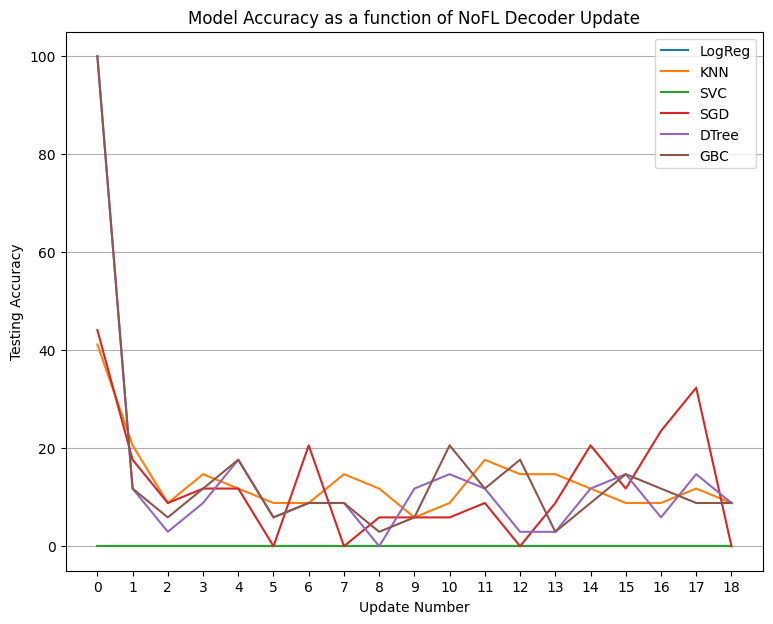

In [19]:
skip_block = 0
col_num = 1
my_x_updates = list(range(19))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, sgd_df.iloc[skip_block:, col_num], label='SGD')
plt.plot(my_x_updates, dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

Accuracies get considerably worse.  From the original (NB 104), we had the following:
- SVC: 80
- LR: 70
- KNN: 57
- GBC: 53
- DTree: 38

## 1 Scipy Step (FL)

In [ ]:
users_c1_1ss = [Client(i, cond1b1_AllInitDecs_list[i], 'EtaScipyMinStep', cond1b1_dict_list[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_c1_1ss = Server(1, D_0_7, 'FedAvg', users_c1_1ss)

big_loop_iters = 500
for i in range(big_loop_iters):
    global_c1_1ss.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_c1_1ss.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(users_c1_1ss, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(global_c1_1ss, 'global', show_update_change=False, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(users_c1_1ss, 'local', dim_reduc_factor=1, plot_gradient=True, local_error=False, global_error=False, custom_title='DRF=1[Off]: GRADIENT')

In [ ]:
users_c2_1ss = [Client(i, cond2b1_AllInitDecs_list[i], 'EtaScipyMinStep', cond2b1_dict_list[i], 'streaming', condition_number=2, delay_scaling=0) for i in range(14)]
global_c3_1ss = Server(-1, D_0, 'FedAvg', users_c2_1ss)

users_c3_1ss = [Client(i, cond2b1_AllInitDecs_list[i], 'EtaScipyMinStep', cond2b1_dict_list[i], 'streaming', condition_number=3, delay_scaling=0) for i in range(14)]
global_c3_1ss = Server(-1, D_0, 'FedAvg', users_c3_1ss)

users_c4_1ss = [Client(i, cond4b1_AllInitDecs_list[i], 'FullScipyMinStep', cond4b1_dict_list[i], 'streaming', condition_number=4, delay_scaling=0) for i in range(14)]
global_c4_1ss = Server(-1, D_0, 'FedAvg', users_c4_1ss)

users_c5_1ss = [Client(i, cond5b1_AllInitDecs_list[i], 'FullScipyMinStep', cond5b1_dict_list[i], 'streaming', condition_number=5, delay_scaling=0) for i in range(14)]
global_c5_1ss = Server(-1, D_0, 'FedAvg', users_c5_1ss)

users_c6_1ss = [Client(i, cond6b1_AllInitDecs_list[i], 'FullScipyMinStep', cond6b1_dict_list[i], 'streaming', condition_number=6, delay_scaling=0) for i in range(14)]
global_c6_1ss = Server(-1, D_0, 'FedAvg', users_c6_1ss)

users_c7_1ss = [Client(i, cond7b1_AllInitDecs_list[i], 'FullScipyMinStep', cond7b1_dict_list[i], 'streaming', condition_number=7, delay_scaling=0) for i in range(14)]
global_c7_1ss = Server(-1, D_0, 'FedAvg', users_c7_1ss)

users_c8_1ss = [Client(i, cond8b1_AllInitDecs_list[i], 'FullScipyMinStep', cond8b1_dict_list[i], 'streaming', condition_number=8, delay_scaling=0) for i in range(14)]
global_c8_1ss = Server(-1, D_0, 'FedAvg', users_c8_1ss)

num_updates_left = 19
for i in range(num_updates_left):
    global_c2.execute_FL_loop()
    global_c3.execute_FL_loop()
    global_c4.execute_FL_loop()
    global_c5.execute_FL_loop()
    global_c6.execute_FL_loop()
    global_c7.execute_FL_loop()
    global_c8.execute_FL_loop()

In [ ]:
t0 = time.time()

df1 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
df2 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
df3 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
df4 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
df5 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
df6 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
df7 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
df8 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
for key_idx, key in enumerate(keys):
    for update_number, update_idx in enumerate(update_ix):
        df1.loc[len(dec_flattened1)] = [key, update_number, np.ravel(users_c1_1ss[key_idx].dec_log[update_number])]
        df2.loc[len(dec_flattened2)] = [key, update_number, np.ravel(users_c2_1ss[key_idx].dec_log[update_number])]
        df3.loc[len(dec_flattened3)] = [key, update_number, np.ravel(users_c3_1ss[key_idx].dec_log[update_number])]
        df4.loc[len(dec_flattened4)] = [key, update_number, np.ravel(users_c4_1ss[key_idx].dec_log[update_number])]
        df5.loc[len(dec_flattened5)] = [key, update_number, np.ravel(users_c5_1ss[key_idx].dec_log[update_number])]
        df6.loc[len(dec_flattened6)] = [key, update_number, np.ravel(users_c6_1ss[key_idx].dec_log[update_number])]
        df7.loc[len(dec_flattened7)] = [key, update_number, np.ravel(users_c7_1ss[key_idx].dec_log[update_number])]
        df8.loc[len(dec_flattened8)] = [key, update_number, np.ravel(users_c8_1ss[key_idx].dec_log[update_number])]        
        
t1 = time.time()
total = t1-t0  
print(total)

In [ ]:
# Concat all the dfs into a single training input dataframe
dec_flattened_1ss = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True, axis=0)

# Make each ele its own cell
expanded_dec_df_1ss = dec_flattened_1ss.join(dec_flattened_1ss['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
expanded_dec_df_1ss.head()

In [ ]:
full_test_df_1ss = make_all_update_models(expanded_dec_df_1ss, stratification=True)
print(full_test_df_1ss.shape)
full_test_df_1ss.head(8)

In [ ]:
lr_df = full_test_df[full_test_df['Algorithm']=='LogisticRegression()']
knn_df = full_test_df[full_test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = full_test_df[full_test_df['Algorithm']=='LinearSVC()']
sgd_df = full_test_df[full_test_df['Algorithm']=='SGDClassifier()']
dt_df = full_test_df[full_test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = full_test_df[full_test_df['Algorithm']=='GradientBoostingClassifier()']

In [ ]:
skip_block = 0
col_num = 1
my_x_updates = list(range(19))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, sgd_df.iloc[skip_block:, col_num], label='SGD')
plt.plot(my_x_updates, dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()